<a href="https://www.kaggle.com/code/yehoryevtushenko/lesson20-03-2024?scriptVersionId=172093490" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install -q optuna

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics
import lightgbm as lgb
import optuna

In [3]:
df = pd.read_csv(r"/kaggle/input/restaurant-revenue-prediction/train.csv.zip")
df = df.drop(columns=['Id','Open Date'])
df.head()

,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,5,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,Tokat,Other,IL,6,4.5,6.0,6.0,4,4,10,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,5,...,3.0,5,1,3,2,3,4,3,3,4316715.0


In [4]:
df['revenue'].describe()

count    1.370000e+02
mean     4.453533e+06
std      2.576072e+06
min      1.149870e+06
25%      2.999068e+06
50%      3.939804e+06
75%      5.166635e+06
max      1.969694e+07
Name: revenue, dtype: float64

In [5]:
y = df['revenue']
X = df.drop(columns='revenue')

cat_columns = X.select_dtypes(include="object").columns
X[cat_columns] = X[cat_columns].astype('category')

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  train_size=0.75,
                                                  random_state=42)

print(f'Train: {X_train.shape[0]} samples \t {round(X_train.shape[0] / X.shape[0] * 100)}%')
print(f'Test:  {X_test.shape[0]} samples \t {round(X_test.shape[0] / X.shape[0] * 100)}%')
print(f'Val:   {X_val.shape[0]} samples \t {round(X_val.shape[0] / X.shape[0] * 100)}%')

Train: 81 samples 	 59%
Test:  28 samples 	 20%
Val:   28 samples 	 20%


In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_columns = X.select_dtypes(include="number").columns
cat_columns = X.select_dtypes(include="object").columns

num_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median"))]
    )

cat_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),
           ])  # можна не кодувати категоріальні дані

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_columns),
        ("cat", cat_transformer, cat_columns),
    ]
)

preprocessor.set_output(transform='pandas')
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 Index(['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11',
       'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21',
       'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31',
       'P32', 'P33', 'P34', 'P35', 'P36', 'P37'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 Index([], dtype='object'))])

In [8]:
X_train = preprocessor.fit_transform(X_train)

X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test) 

In [9]:
from sklearn import metrics

def objective(trial):
  params = {
        "objective": "mse",
        "verbosity": -1,
        "n_estimators": 30,
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1.0, log=True),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "learning_rate":trial.suggest_float("learning_rate",1e-8,10, log=True)
  }

  model = lgb.LGBMRegressor(**params)

  model.fit(X_train, y_train)

  y_pred = model.predict(X_val)
  r2 = metrics.r2_score(y_val, y_pred)

  return r2

In [10]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

/opt/conda/lib/python3.10/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "learning_rate"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'step': None, 'low': 1e-08, 'high': 1.0, 'log': True}
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "learning_rate"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'step': None, 'low': 1e-08, 'high': 1.0, 'log': True}
  warnings.warn(
/opt/conda

In [11]:
print(f"Best metric: {study.best_value}")

Best metric: 0.22266482234175944


In [12]:
best_params = study.best_params

model = lgb.LGBMRegressor(**best_params,
                          verbose=-1, n_estimators=1000)

model.fit(X_train, y_train,
          eval_set=[(X_test, y_test), (X_train, y_train)],
          eval_metric='mae')

LGBMRegressor(bagging_fraction=0.6435234322713563, bagging_freq=2,
              feature_fraction=0.9724029442098749,
              lambda_l1=1.1952111635747986e-06,
              lambda_l2=4.0368009126675005e-05,
              learning_rate=0.9854962318921197, min_child_samples=16,
              n_estimators=1000, num_leaves=24, verbose=-1)

In [13]:
def get_metrics(y_true, y_pred, name="model"):
  df = pd.DataFrame()

  df.loc["MAE", name] = metrics.mean_absolute_error(y_true, y_pred)
  df.loc["RMSE", name] = metrics.mean_squared_error(y_true, y_pred) ** 0.5
  df.loc["R2", name] = metrics.r2_score(y_true, y_pred)

  return df.round(2)
     

all_metrics = pd.DataFrame()

all_metrics["train"] = get_metrics(y_train, model.predict(X_train))
all_metrics["test"] = get_metrics(y_test, model.predict(X_test))

all_metrics

,train,test
MAE,325212.22,3065078.29
RMSE,458067.20,4435499.42
R2,0.93,-0.61


In [14]:
optuna.visualization.plot_param_importances(study)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

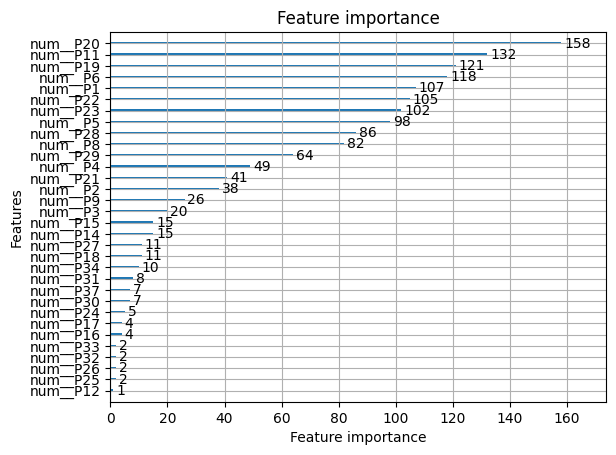

In [15]:
lgb.plot_importance(model)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l1'>

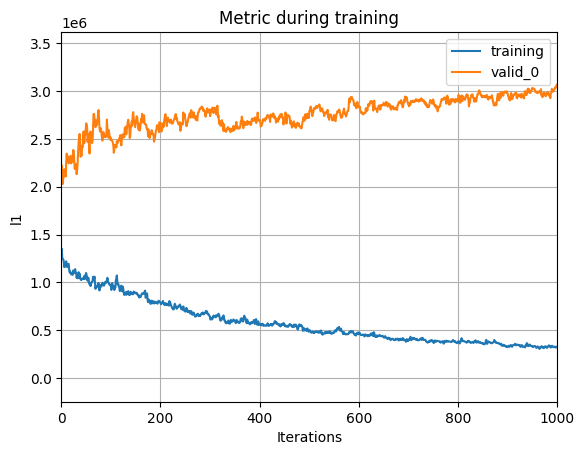

In [16]:
lgb.plot_metric(model,
                metric='l1')

In [17]:
model = Pipeline(
    [("prep", preprocessor),
     ("model", model)
     ]
)

model

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11',
       'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21',
       'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31',
       'P32', 'P33', 'P34', 'P35', 'P36', 'P37'],
      dty...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  Index([], dtype='object'))])),
                ('model',
                 LGBMRegressor(bagging_fraction=0.6435234322713563,
                               bagging_freq=2,
                               feature_fraction=0.9724029442098749,
                               lambda_l1=1.1952111635747986e-06,
                               lambda_l2=4.0368009126675005e-05,
                               learning_rate=0.9854962318921197,
                               min_child_samples=16, n_estimators=1000,
                               num_leaves=24, verbose=-1))])